# Cheap Cow

Wir illustrieren hier das einfache Schichtenplanungsmodell aus Abschnitt 6.1). Zunächst die nötigen <code>import</code>.

In [1]:
import random
import matplotlib.pyplot as plt
### Wir benutzen das seaborn style, damit die plots ein bisschen hübscher aussehen
plt.style.use('seaborn-v0_8')

# Wenn Sie Colab nicht nutzen, dann kommentieren Sie die nächste
# Zeile aus. Sie müssen dann selbst dafür sorgen, dass mip installiert ist
!pip install mip
import mip

Wir definieren hier relativ willkürlich eine Instanz. Die Instanz besteht aus <code>T</code>, den Zeitblöcken, <code>S</code> den Schichten, <code>c</code>, den Kosten der jeweiligen Schicht, und <code>r</code>, dem Bedarf an Arbeitskräften pro Zeitblock.

In [2]:
## die Zeitblöcke
T=range(6,27)
## die Schichten, jeweils definiert durch Anfangs- und Endzeitpunkt
S=[(6,14),(10,18),(14,22),(18,26)]  ## wir stellen 2h nachts als 26 dar
## die Kosten der Schichten; die späteren Schichten sind teurer
c=[1,1,1.5,2]

## als letztes erzeugen wir den Bedarf r
def make_peak(t0,m,a):
    return lambda t: max(0,a-m*abs(t-t0))

even_peak=make_peak(20,1.7,8)
mid_peak=make_peak(12,2,6)
random.seed(42)
noise=lambda : random.randint(0,2)
R=[round(mid_peak(t)+even_peak(t))+noise()+1 for t in T]
r=dict([(t,rr) for t,rr in zip(T,R)])

Um einfacher den Bedarf pro Zeit zu ermitteln, ist <code>r</code> ein dictionary.

In [3]:
r[12]

7

Wir plotten den Bedarf <code>r</code>.

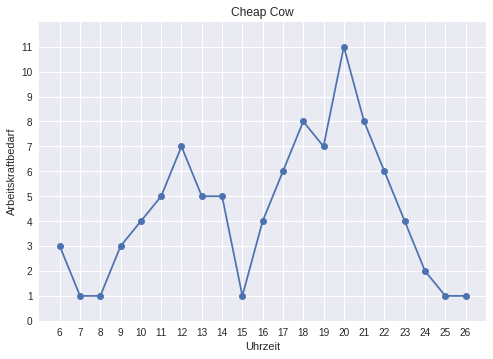

In [4]:
plt.yticks(range(0,max(R)+1))
plt.ylim(0,max(R)+1)
plt.xticks(T)
plt.xlabel('Uhrzeit')
plt.ylabel('Arbeitskraftbedarf')
plt.title('Cheap Cow')
plt.plot(T,R,'o-')

## Das MIP

Das MIP:

\begin{align}
\min  \sum_{s\in S}c_sx_s&\\
\text{unter }
\sum_{s\in S, t\in s}x_s\geq r_t & \quad t=1,\ldots, T\\
x_s\geq 0,x_s\in\mathbb Z & \quad s=1\in S
\end{align}

Wir starten wieder mit Variablen, die wir ganzzahlig (und nicht-negativ) haben wollen. 

In [5]:
m=mip.Model()
x=[m.add_var(var_type=mip.INTEGER) for _ in S]

Wir stellen nun sicher, dass der Bedarf gedeckt ist. Man beachte die Aufzählung mit Filter (die <code>if</code>-Bedingung in der Aufzählung).

In [6]:
for t in T:
    m+=mip.xsum(x[i] for i,s in enumerate(S) if s[0]<=t and t<=s[1])>=r[t]

Die Zielfunktion.

In [7]:
m.objective=mip.minimize(mip.xsum(x[i]*c[i] for i,_ in enumerate(x)))
m.optimize()

<OptimizationStatus.OPTIMAL: 0>

Wir plotten das Ergebnis.

Text(0, 0.5, 'Anzahl Arbeitskräfte')

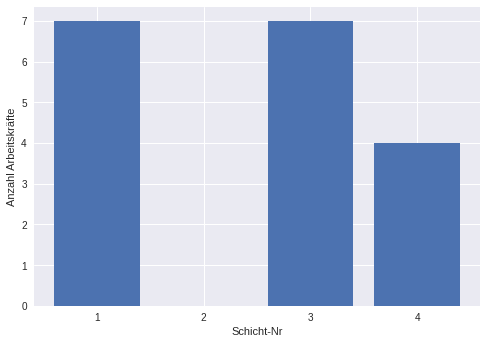

In [8]:
plt.bar(range(1,5),[xx.x for xx in x])
plt.xticks(range(1,5))
plt.xlabel('Schicht-Nr')
plt.ylabel('Anzahl Arbeitskräfte')